# Linear regression with Professor Mittens, a.k.a. recipe for linear regression.

## Overview

In this notebook we will learn how to use regression to study the factors that affect the number of pats cats will recieve. This will start with a visual inspection of the data, followed by the development of a linear model to explain the data. Along the way we will answer a few questions such as: does coat colour influence the number of pats, is a long coat better than a short coat, and how important is the volume of a meow.

## Specifying regression models

A very popular way to describe regression models is with "formulae" as popularised by R. The [R documentation on formulae](https://cran.r-project.org/doc/manuals/R-intro.html#Formulae-for-statistical-models) is a good place to learn how to use these properly. For example, here is the syntax we will use today,

- `y ~ x1 + x2` will make a linear model with the predictors $x_1$ and $x_2$.
- `y ~ x1 * x2` includes the terms $x_1 + x_2 + x_1x_2$
- `y ~ x1 : x2` includes *just* the interaction term $x_1x_2$
- `y ~ 1 + x` explicitly states that there should be an intercept term
- `y ~ 0 + x` explicitly states that there should _not_ be an intercept term
- `y ~ .` in R would mean all the variables but not in statsmodels
- `y ~ C(x)` specifies that $x$ is a catagorical variable **NOTE** this is not necessary in R.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import altair as alt
from functools import reduce

## Helping cats get more pats

Professor Mittens in interested in helping cats optimise the number of pats they can get. To learn more about this, he has interviewed 1000 cats and taken measurements of their behaviour and appearance. The data in `cat-pats.csv` contains measurments of the following:

- `time_outdoors` is the number of hours that the cat is out of their primary dwelling,
- `coat_colour` is either tortoiseshell, white, or "other" encoded as integers 1, 2, and 3 respectively,
- `weight` is the weight of the cat in kilograms,
- `height` is their height in centimeters,
- `loudness` is a measure of how loud their meow is, the units are not known,
- `whisker_length` is the length of their whiskers in centimeters,
- `is_longhaired` is a Boolean variable equal to 1 if the cat is of a longhaired breed and 0 if it is of a shorthaired breed,
- `coat_length` is the length of their fur in centimeters,
- and `num_pats` is the number of pats they received on the day they were interviewed.

The variable we are interested in explaining is `num_pats`. Although this is a discrete variable, we will ignore this aspect of the data and consider it as a continuous value. This is a useful simplifying assumption, as you learn more about regression, in particular generalized linear models, you will see additional ways to handle this. For this example, you can consider it a continuous variable though.

The types of questions that Professor Mittens is interested in answering are as follows:

1. Do any of the variables correlate with the number of pats that the cats recieve?
2. Under a naive model, how much of the variability in pats can they explain? Do all the variables need to be included?
3. Does the coat colour matter?
4. Among short-haired breeds they say longer hair is better, among long-haired breeds they say short hair is better, who is correct?
5. **If a cat can choose to spend more time outdoors, or practise meowing louder, which will get them more pats?**

### Read in the data and generate some scatter plots to see if there are any good predictors of the number of pats

The data is in the file `cat-pats.csv` so read this into a data frame using `pd.read_csv` and go from there. I have used altair to generate my scatter plots based on [this example](https://altair-viz.github.io/gallery/scatter_matrix.html) but you can use whatever you feel most comfortable with. It might be useful to use colour to see if `coat_colour` and `is_longhaired` are important. 

### Question

Based on these figures, what variables appear to relate to the number of pats? What do you notice about the catagorical variables `coat_colour` and `is_longhaired`?

In [3]:
cat_df = pd.read_csv("cat-pats.csv")

In [4]:
col_names = cat_df.columns.tolist()
predictor_names = col_names.copy()
predictor_names.remove("num_pats")

alt.Chart(cat_df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative', scale=alt.Scale(zero=False)),
    alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    color = "is_longhaired:O"
).properties(
    width=100,
    height=100
).repeat(
    row=["num_pats"],
    column=predictor_names
)

alt.RepeatChart(...)

In [5]:
alt.Chart(cat_df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative', scale=alt.Scale(zero=False)),
    alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    color = "coat_colour:O"
).properties(
    width=100,
    height=100
).repeat(
    row=["num_pats"],
    column=predictor_names
)

alt.RepeatChart(...)

### Partial answer

- Based on the plots, it looks like the time the cat spends outdoors and their coat length (both whether they are a longhaired breed and the actual length of their fur) are important.
- Also note that when you colour based on whether the breed is a long hair some of the data seems to cluster while this is not the case in for the colour of the coat.

### Compute the correlation between each variable and the number of pats, what looks important

### Question

Does the the correlation matrix raise any further questions? Does it handle the catagorical variables correctly?

In [6]:
cat_df.corr()

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
time_outdoors,1.000000,0.011325,0.020449,-0.018438,0.029064,0.033036,-0.007209,-0.023776,0.408470
coat_colour,0.011325,1.000000,0.048857,0.004303,0.067005,0.027979,0.034950,0.044578,0.351635
weight,0.020449,0.048857,1.000000,0.020759,0.037379,0.040600,0.001120,-0.003659,0.078798
height,-0.018438,0.004303,0.020759,1.000000,0.015115,0.731840,0.017102,-0.004469,0.109457
loudness,0.029064,0.067005,0.037379,0.015115,1.000000,0.543422,0.013643,0.016147,0.075420
whisker_length,0.033036,0.027979,0.040600,0.731840,0.543422,1.000000,0.004634,-0.006210,0.140842
is_longhaired,-0.007209,0.034950,0.001120,0.017102,0.013643,0.004634,1.000000,0.788381,-0.497761
coat_length,-0.023776,0.044578,-0.003659,-0.004469,0.016147,-0.006210,0.788381,1.000000,-0.416950
num_pats,0.408470,0.351635,0.078798,0.109457,0.075420,0.140842,-0.497761,-0.416950,1.000000


### Partial answer

- There is a strong relationship between whisker length and height which we had not seen in the plots above.
- Since the catagorical variables were encoded as numbers they are being handled as qualitative variables so the reported values are not correct for those rows/columns.

### What is $R^2$?

Sometimes called the *coefficient of determination*, this statistic measures the proportion of the variance in the response variable that is explained by the regression model. In the case of simple linear regression it is just the correlation squared, it can also be calculated as the ratio of the regression sum of squares and the total sum of squares. 

$$
R^2 = \frac{\text{RegSS}}{\text{TSS}}
$$

It can be thought of as the proportion of the total variance that is explained by the regression model.

### What is an *adjusted* $R^2$?

For a fixed number of observations, as the number of covariates increases you can get explain as much of the variability as you want! The adjusted $R^2$ is a way to penalise using too many covariates. The adjusted $R^2$ for a model with $n$ observations and $p$ coefficients is given by the following:

$$
\tilde{R}^2 = 1 - \frac{n - 1}{n - p}\left(1 - R^2\right)
$$

### Under a naive model, how much of the variability in pats can they explain?

Run an ordinary linear regression with all of the variables and see what percentage of the variability in the number of pats is explained. Make sure that you have used the catagorical variables correctly. Can be be confident in rejecting the null hypothesis that none of these variables is associated with the number of pats received?

In [6]:
lm_1 = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + whisker_length + C(is_longhaired) + coat_length", cat_df).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     146.4
Date:                Thu, 12 Nov 2020   Prob (F-statistic):          4.17e-175
Time:                        15:16:57   Log-Likelihood:                -3240.1
No. Observations:                1000   AIC:                             6500.
Df Residuals:                     990   BIC:                             6549.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.50

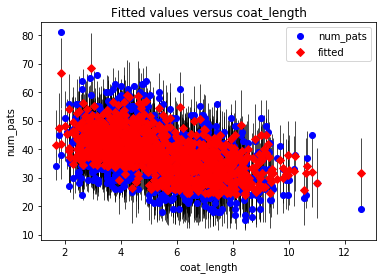

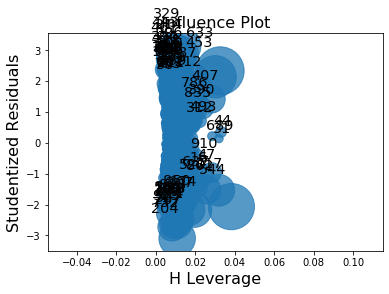

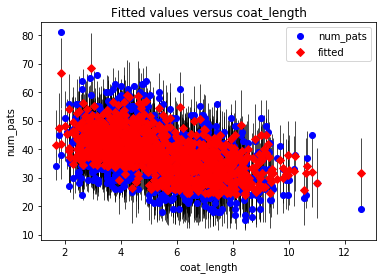

In [7]:
sm.graphics.influence_plot(lm_1, criterion="cooks")
sm.graphics.plot_fit(lm_1, "coat_length")

In [8]:
cat_df[543:546]

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
543,3.361139,1,3.685847,23.939379,2.483834,8.252826,1,6.629628,35
544,3.294114,3,4.231563,21.866053,3.715987,7.105908,1,12.573740,19
545,8.039386,1,3.729648,23.569140,2.247019,7.714122,1,5.631064,23


In [9]:
cat_df.describe()

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.035366,1.96700,3.991534,23.986785,3.256364,8.171950,0.494000,5.461403,38.086000
std,3.584645,0.81889,0.500643,1.140039,0.840721,0.468196,0.500214,1.903036,9.437567
min,0.154231,1.00000,2.430003,19.939328,1.616797,6.682087,0.000000,1.711976,15.000000
25%,3.350706,1.00000,3.668124,23.198559,2.625019,7.867283,0.000000,3.879987,31.000000
50%,5.396088,2.00000,3.997326,23.969937,3.318276,8.147573,0.000000,5.307417,38.000000
75%,8.008499,3.00000,4.333097,24.727161,3.854054,8.466936,1.000000,6.938242,44.000000
max,24.000000,3.00000,5.493976,28.184376,6.179538,9.769214,1.000000,12.573740,81.000000


### Question: Is colinearity an issue in this model? Do all of the variables need to be included?

Compute the VIF to see if there is a concerning amount of colinearity between any of the covariates.

In [10]:
col_names = cat_df.copy().columns.tolist()
col_names.remove("num_pats")

def join_strings(xs, sep):
    return reduce(lambda a, b: a + sep + b, xs)
    
for v in col_names:
    cns = col_names.copy()
    cns.remove(v)
    formula = v + " ~ " + join_strings(cns, " + ")
    coef_det = smf.ols(formula, data = cat_df).fit()
    vif = 1 / (1 - coef_det.rsquared)
    if vif > 3:
        print("\n" + 80 * "=")
        print(v)
        print(vif)


height
3.9252690754622748

whisker_length
5.567432673116362


In [11]:
lm_3 = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + C(is_longhaired) + coat_length", cat_df).fit()
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     164.7
Date:                Thu, 12 Nov 2020   Prob (F-statistic):          3.82e-176
Time:                        15:16:59   Log-Likelihood:                -3240.3
No. Observations:                1000   AIC:                             6499.
Df Residuals:                     991   BIC:                             6543.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.52

## Partial answer

The VIF of whisker length is >5 and removing it does not reduce the $R^2$ and means that loudness is now closer to being significant. Together this suggests that there was some colinearity there, so removing the whisker length variable seems sensible.

### Does coat colour matter?

1. Make a box plot of the number of pats by coat colour to see this pattern.
2. Fit an additional linear model without the coat colour as a covariate to see how much of the explained variability comes from the inclusion of coat colour in the model.

In [12]:
coat_df = cat_df.loc[:,["coat_colour", "num_pats"]].copy()
alt.Chart(coat_df).mark_boxplot().encode(
    x='coat_colour:O',
    y='num_pats:Q'
).properties(
    width=600,
    height=300
)


alt.Chart(...)

In [13]:
lm_with_colour = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + C(is_longhaired) + coat_length", cat_df).fit()
lm_without_colour = smf.ols("num_pats ~ time_outdoors + weight + height + loudness + C(is_longhaired) + coat_length", cat_df).fit()

a = (lm_with_colour.resid ** 2).sum()
b = (lm_without_colour.resid ** 2).sum()

(b - a) / b

0.2374840382529738

### Partial answer

The box plots show that tortoiseshell cats tend to get fewer pats than white cats which get fewer than any other colour. The coat colour is an important predictor to include, it accounts for about 20% of the residual sum of squares without coat colour

### Among short-haired breeds they say longer hair is better, among long-haired breeds they say short hair is better, who is correct?

Since in the figures above we saw that the breed longhaired/shorthaired appears to separate the data, it may be useful to consider different models on each subset. Fit a linear model to each subset of the data and see that the effect of the coat length is in each case.

In [14]:
lm_4a = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + coat_length", cat_df[cat_df["is_longhaired"] == 1]).fit()
lm_4b = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + coat_length", cat_df[cat_df["is_longhaired"] == 0]).fit()

In [15]:
print(lm_4a.summary())

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     55.53
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           3.57e-58
Time:                        15:16:59   Log-Likelihood:                -1563.8
No. Observations:                 494   AIC:                             3144.
Df Residuals:                     486   BIC:                             3177.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0011    

### Partial answer

When we fit the model to each subset of the data we see that the coefficient changes direction suggesting there is an interaction here.

### Fit a model with an interacion term between the coat length and the long/shorthaired breed

What does this tell us about the age old debate about cat hair length?

In [16]:
lm_4c = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + C(is_longhaired) : coat_length", cat_df).fit()
print(lm_4c.summary())

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     170.5
Date:                Thu, 12 Nov 2020   Prob (F-statistic):          2.10e-180
Time:                        15:16:59   Log-Likelihood:                -3230.3
No. Observations:                1000   AIC:                             6479.
Df Residuals:                     991   BIC:                             6523.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

the principle of marginality tells us in general we should include the main effects... but here we showed that we can remove the main effects and just include the interaction term

i.e. use the * and not the :

### Partial answer

Fitting the model with an interaction term suggests that both are correct: if you are a shorthaired breed, increasing your coat lenght tends to increase the number of pats and if you are a longhaired breed it will decrease the number of pats on average.

### How else could we handle coat length?

We could instead have included quadratic terms for coat length to see if this was a better way to explain the non-linear effect.

### Shouldn't we check for influential points?

We can generate a plot of the studentized residuals and the leverage to check if there are any influential points.

If there is a potential outlier, does removing it change anything?

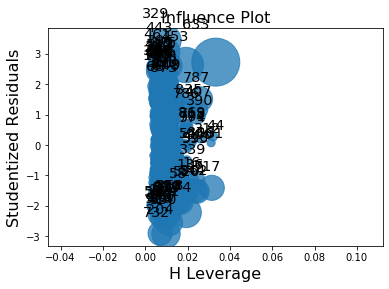

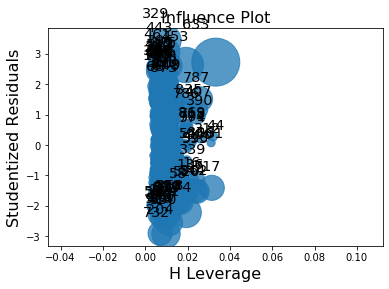

In [17]:
sm.graphics.influence_plot(lm_4c, criterion="cooks")

In [18]:
cat_df[630:635]

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
630,5.295400,1,3.218232,23.496838,2.012904,7.362649,1,5.384057,21
631,6.012840,2,3.661022,22.772578,2.524154,7.528472,0,3.566861,40
632,5.805834,3,3.668990,22.697557,3.288929,7.941635,1,6.042446,35
633,24.000000,3,4.139343,23.515620,3.465041,8.343535,0,1.858150,81
634,13.037910,2,3.707755,23.864526,3.971520,8.490644,1,6.105874,39


In [19]:
cat_df.describe()

,time_outdoors,coat_colour,weight,height,loudness,whisker_length,is_longhaired,coat_length,num_pats
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.035366,1.96700,3.991534,23.986785,3.256364,8.171950,0.494000,5.461403,38.086000
std,3.584645,0.81889,0.500643,1.140039,0.840721,0.468196,0.500214,1.903036,9.437567
min,0.154231,1.00000,2.430003,19.939328,1.616797,6.682087,0.000000,1.711976,15.000000
25%,3.350706,1.00000,3.668124,23.198559,2.625019,7.867283,0.000000,3.879987,31.000000
50%,5.396088,2.00000,3.997326,23.969937,3.318276,8.147573,0.000000,5.307417,38.000000
75%,8.008499,3.00000,4.333097,24.727161,3.854054,8.466936,1.000000,6.938242,44.000000
max,24.000000,3.00000,5.493976,28.184376,6.179538,9.769214,1.000000,12.573740,81.000000


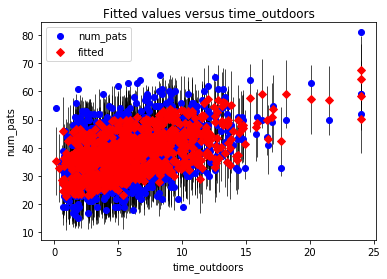

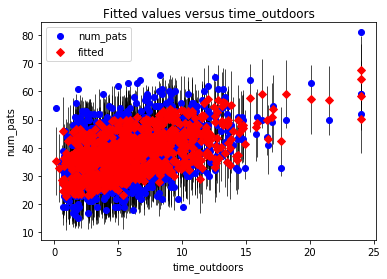

In [20]:
sm.graphics.plot_fit(lm_4c, "time_outdoors")

In [21]:
# Warning!
# ========
# We have to be very careful removing data or only work with copies of the
# dataframe.
cat_df_2 = cat_df.copy()
print(cat_df_2[632:635])
cat_df_2.drop([633], axis=0, inplace=True)
print(80 *"=")
print(cat_df_2[633:635])

     time_outdoors  coat_colour    weight     height  loudness  \
632       5.805834            3  3.668990  22.697557  3.288929   
633      24.000000            3  4.139343  23.515620  3.465041   
634      13.037910            2  3.707755  23.864526  3.971520   

     whisker_length  is_longhaired  coat_length  num_pats  
632        7.941635              1     6.042446        35  
633        8.343535              0     1.858150        81  
634        8.490644              1     6.105874        39  
     time_outdoors  coat_colour    weight     height  loudness  \
634      13.037910            2  3.707755  23.864526  3.971520   
635       4.295067            2  3.335932  25.702148  2.614308   

     whisker_length  is_longhaired  coat_length  num_pats  
634        8.490644              1     6.105874        39  
635        8.325854              0     2.542713        49  


In [22]:
lm_5 = smf.ols("num_pats ~ time_outdoors + C(coat_colour) + weight + height + loudness + C(is_longhaired) : coat_length", cat_df_2).fit()
print(lm_5.summary())
print(lm_4c.summary())

                            OLS Regression Results                            
Dep. Variable:               num_pats   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     166.4
Date:                Thu, 12 Nov 2020   Prob (F-statistic):          2.43e-177
Time:                        15:17:01   Log-Likelihood:                -3223.8
No. Observations:                 999   AIC:                             6466.
Df Residuals:                     990   BIC:                             6510.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### Partial answer 

Point 633 did stand out due to the large amount of time spent outside and the large number of pats, but removing them had very little effect on the parameter estimates.

### Should a cat practise meowing or just spend more time outdoors to get more pats?

We can just look at the coefficients to see that a much more efficient way to get pats is to be outside, the relationship between loudness and number of pats is not supported by this data set.